---
# Imports

In [1]:
import json
from rich import print as rprint
import pandas as pd
import numpy as np

import warnings
# Filter the specific UserWarning from torch regarding TF32/matmul precision
warnings.filterwarnings("ignore", category=UserWarning, module="torch")

import torch
torch.set_float32_matmul_precision('high')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import cv2
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes, make_rgb_axes

import pickle
from tqdm import tqdm

print('OpenCV version: ', cv2.__version__)

OpenCV version:  4.12.0


In [2]:
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)

seed_everything(42)


---
# Load data

In [3]:
# Read Training Data CSV
df_train = pd.read_csv('../data/raw/Training/Train.csv')

In [4]:
# Drop image 332 due to corrupted file
df_train = df_train[df_train['image_id'] != 332].reset_index(drop=True)

In [6]:
# Read Cropped RGB images - image values [0,255]

rgb_path_train = '../data/processed/crops/Training/RGBImages/'

cropped_rgb_images_train = {}

for image_id in df_train['image_id'].values:
    if image_id % 332 == 0:
        continue
    img = cv2.imread(rgb_path_train + 'cropped_RGB_' + str(image_id) + '.png', cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_rgb_images_train[image_id] = img
print(f'Loaded {len(cropped_rgb_images_train)} training images.')


Loaded 230 training images.


In [7]:
# Read Depth images - image values - 16 bit
depth_path_train = '../data/processed/crops/Training/DepthImages/'

cropped_depth_images_train = {}

for image_id in df_train['image_id'].values:
    if image_id % 332 == 0:
        continue
    img = cv2.imread(depth_path_train + 'cropped_Depth_' + str(image_id) + '.png', cv2.IMREAD_UNCHANGED)
    cropped_depth_images_train[image_id] = img
print(f'Loaded {len(cropped_depth_images_train)} training depth images.')


Loaded 230 training depth images.


In [8]:
# Read lettuce masks
lettuce_masks_path_train = '../data/processed/masks_inferred/Train/'

cropped_lettuce_masks_train = {}

for image_id in df_train['image_id'].values:
    if image_id % 332 == 0:
        continue
    img = cv2.imread(f'{lettuce_masks_path_train}{str(image_id)}_lettuce.png', cv2.IMREAD_UNCHANGED)
    cropped_lettuce_masks_train[image_id] = img
print(f'Loaded {len(cropped_lettuce_masks_train)} training masks.')


Loaded 230 training masks.


In [9]:
# Read crate masks
crate_masks_path_train = '../data/processed/masks_inferred/Train/'

cropped_crate_masks_train = {}

for image_id in df_train['image_id'].values:
    if image_id % 332 == 0:
        continue
    img = cv2.imread(f'{crate_masks_path_train}{str(image_id)}_lettuce.png', cv2.IMREAD_UNCHANGED)
    cropped_crate_masks_train[image_id] = img
print(f'Loaded {len(cropped_crate_masks_train)} training masks.')


Loaded 230 training masks.


In [10]:
# Check that every training image has a lettuce mask
missing_masks = []
for image_id in df_train['image_id'].values:
    if image_id % 332 == 0:
        continue
    if image_id not in cropped_lettuce_masks_train:
        missing_masks.append(image_id)
print(f'Missing masks for training images: {missing_masks}')


Missing masks for training images: []


In [11]:
# Check that every training image has a crate mask
missing_masks = []
for image_id in df_train['image_id'].values:
    if image_id % 332 == 0:
        continue
    if image_id not in cropped_crate_masks_train:
        missing_masks.append(image_id)
print(f'Missing masks for training images: {missing_masks}')


Missing masks for training images: []


---
# Pre-Process

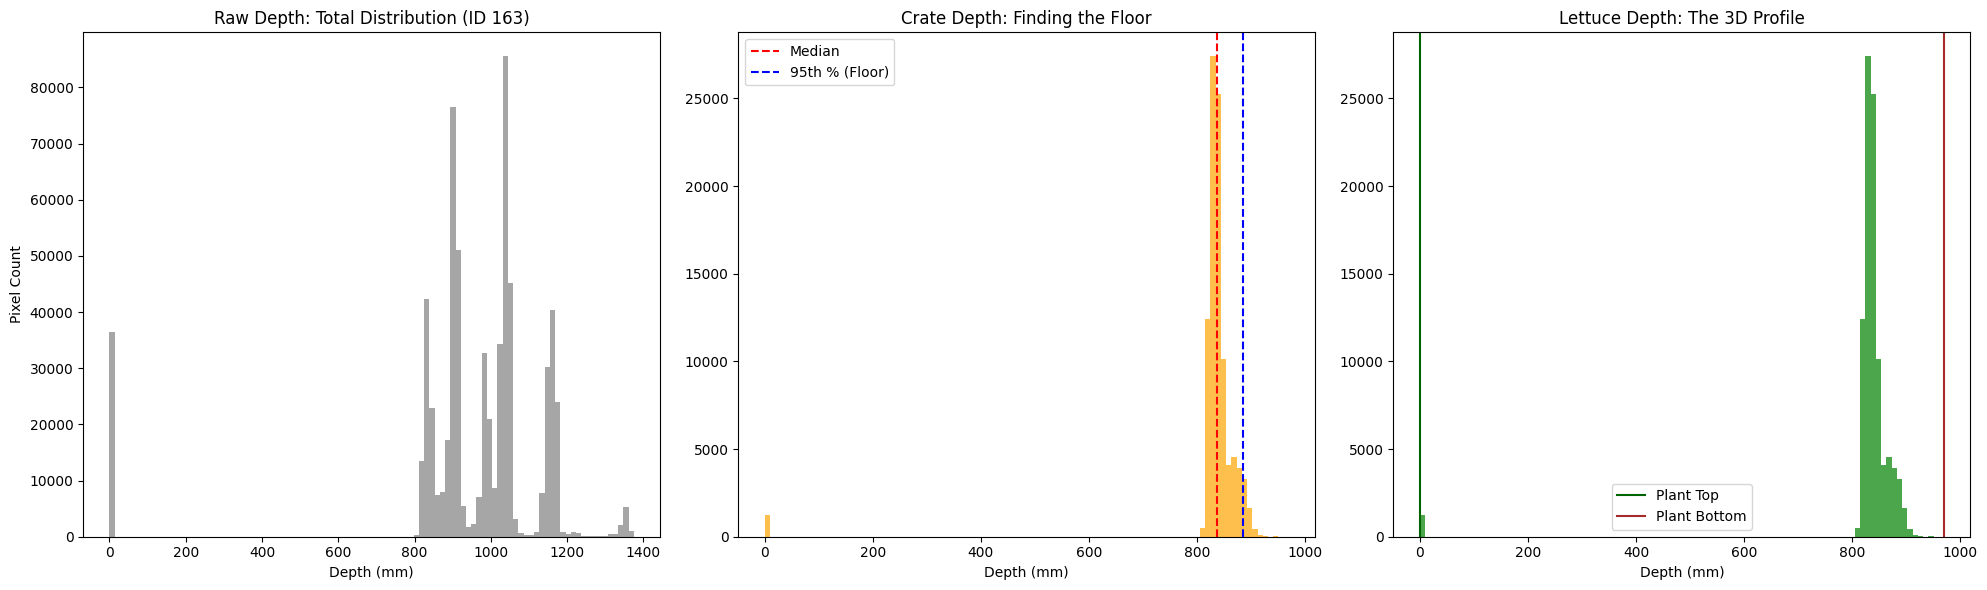

--- ID 163 DEPTH ANALYSIS ---
Crate Median: 836.00
Crate 95th % (Suggested Floor): 885.00
Lettuce Min (Closest to Camera): 0.00
Difference (Max Potential Height): 885.00 mm


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Target ID for analysis
img_id = 163

# 1. Extract the raw depth and the specific masked regions
depth = cropped_depth_images_train[img_id]
crate_mask = cropped_crate_masks_train[img_id]
lettuce_mask = cropped_lettuce_masks_train[img_id]

raw_vals = depth.flatten()
# Filter out 0 or nan values if they exist
crate_vals = depth[crate_mask > 0]
lettuce_vals = depth[lettuce_mask > 0]

# 2. Setup the side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Histogram 1: Full Image (The 'Big Picture')
axes[0].hist(raw_vals, bins=100, color='gray', alpha=0.7)
axes[0].set_title(f'Raw Depth: Total Distribution (ID {img_id})')
axes[0].set_xlabel('Depth (mm)')
axes[0].set_ylabel('Pixel Count')

# Histogram 2: Crate Only (The 'Baseline')
axes[1].hist(crate_vals, bins=100, color='orange', alpha=0.7)
axes[1].set_title('Crate Depth: Finding the Floor')
axes[1].set_xlabel('Depth (mm)')
# Add lines for median and 95th percentile to see the 'Rim vs Floor'
axes[1].axvline(np.median(crate_vals), color='red', linestyle='--', label='Median')
axes[1].axvline(np.percentile(crate_vals, 95), color='blue', linestyle='--', label='95th % (Floor)')
axes[1].legend()

# Histogram 3: Lettuce Only (The 'Signal')
axes[2].hist(lettuce_vals, bins=100, color='green', alpha=0.7)
axes[2].set_title('Lettuce Depth: The 3D Profile')
axes[2].set_xlabel('Depth (mm)')
# Add lines for min (top of plant) and max (bottom of plant)
axes[2].axvline(np.min(lettuce_vals), color='darkgreen', linestyle='-', label='Plant Top')
axes[2].axvline(np.max(lettuce_vals), color='brown', linestyle='-', label='Plant Bottom')
axes[2].legend()

plt.tight_layout()
plt.show()

# 3. Print the quantitative values for the math check
print(f"--- ID {img_id} DEPTH ANALYSIS ---")
print(f"Crate Median: {np.median(crate_vals):.2f}")
print(f"Crate 95th % (Suggested Floor): {np.percentile(crate_vals, 95):.2f}")
print(f"Lettuce Min (Closest to Camera): {np.min(lettuce_vals):.2f}")
print(f"Difference (Max Potential Height): {np.percentile(crate_vals, 95) - np.min(lettuce_vals):.2f} mm")

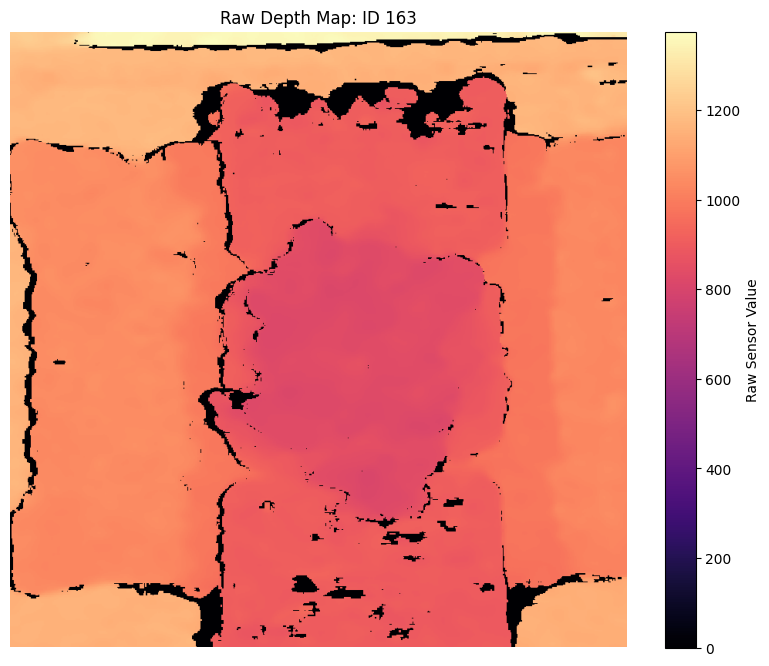

ID 163 Value Range: 0 to 1375


In [13]:
import matplotlib.pyplot as plt
import numpy as np

img_id = 163
depth_img = cropped_depth_images_train[img_id]

plt.figure(figsize=(10, 8))
# Using 'magma' because it's great for depth; 
# We'll use the raw values to see exactly what the sensor sees.
plt.imshow(depth_img, cmap='magma')
plt.title(f"Raw Depth Map: ID {img_id}")
plt.colorbar(label='Raw Sensor Value')
plt.axis('off')
plt.show()

print(f"ID {img_id} Value Range: {np.min(depth_img)} to {np.max(depth_img)}")

In [14]:
import numpy as np
from tqdm import tqdm

def establish_competition_constants(depth_dict, crate_mask_dict, lettuce_mask_dict):
    all_floor_depths = []
    all_plant_heights = []

    for key in tqdm(depth_dict.keys(), desc="Analyzing Training Stats"):
        depth = depth_dict[key].astype(np.float32)
        c_mask = (crate_mask_dict[key] > 0)
        l_mask = (lettuce_mask_dict[key] > 0)

        # 1. Find the floor (furthest valid point in the crate)
        # We ignore 0s and use 95th percentile to skip rims
        valid_crate = depth[(c_mask) & (depth > 0)]
        if valid_crate.size > 0:
            all_floor_depths.append(np.percentile(valid_crate, 95))
        
    # Global Floor is the median of all 'deepest' crate points
    Z_GLOBAL_FLOOR = np.median(all_floor_depths)

    # 2. Find the Global Max Height relative to that floor
    for key in depth_dict.keys():
        depth = depth_dict[key].astype(np.float32)
        l_mask = (lettuce_mask_dict[key] > 0)
        
        valid_lettuce = depth[(l_mask) & (depth > 0)]
        if valid_lettuce.size > 0:
            # Physical height = Floor - Plant Depth
            # We use 99th percentile of the plant to ignore edge spikes
            heights = Z_GLOBAL_FLOOR - valid_lettuce
            all_plant_heights.append(np.percentile(heights, 99))

    # Add 10% buffer to protect against larger plants in Final Test
    GLOBAL_MAX_HEIGHT = np.max(all_plant_heights) * 1.10
    
    return Z_GLOBAL_FLOOR, GLOBAL_MAX_HEIGHT

# Run on TRAIN
Z_FLOOR, G_MAX = establish_competition_constants(
    cropped_depth_images_train, 
    cropped_crate_masks_train, 
    cropped_lettuce_masks_train
)
print(f"Locked Constants -> Floor: {Z_FLOOR:.1f}mm, Max Height Scale: {G_MAX:.1f}mm")

Analyzing Training Stats: 100%|██████████| 230/230 [00:00<00:00, 934.81it/s]


Locked Constants -> Floor: 865.0mm, Max Height Scale: 217.8mm


In [15]:
def generate_standardized_heights(depth_dict, lettuce_mask_dict, z_floor, g_max):
    processed_dict = {}
    
    for key in depth_dict.keys():
        depth = depth_dict[key].astype(np.float32)
        l_mask = (lettuce_mask_dict[key] > 0)
        
        # 1. Calculate height from the floor
        # Standard: Floor (e.g. 1000) - Plant Depth (e.g. 850) = 150mm height
        raw_height = z_floor - depth
        
        # 2. Normalize and Clip
        # This keeps a 5cm plant dim and a 20cm plant bright
        norm_height = np.clip(raw_height / g_max, 0, 1)
        
        # 3. Apply Noise & Lettuce Filters
        # - (l_mask): Deletes crate rims/background
        # - (depth > 0): Deletes the black sensor spikes
        final_map = norm_height * l_mask * (depth > 0)
        
        processed_dict[key] = final_map.astype(np.float32)
        
    return processed_dict

# Apply to all sets
height_maps_train = generate_standardized_heights(cropped_depth_images_train, cropped_lettuce_masks_train, Z_FLOOR, G_MAX)

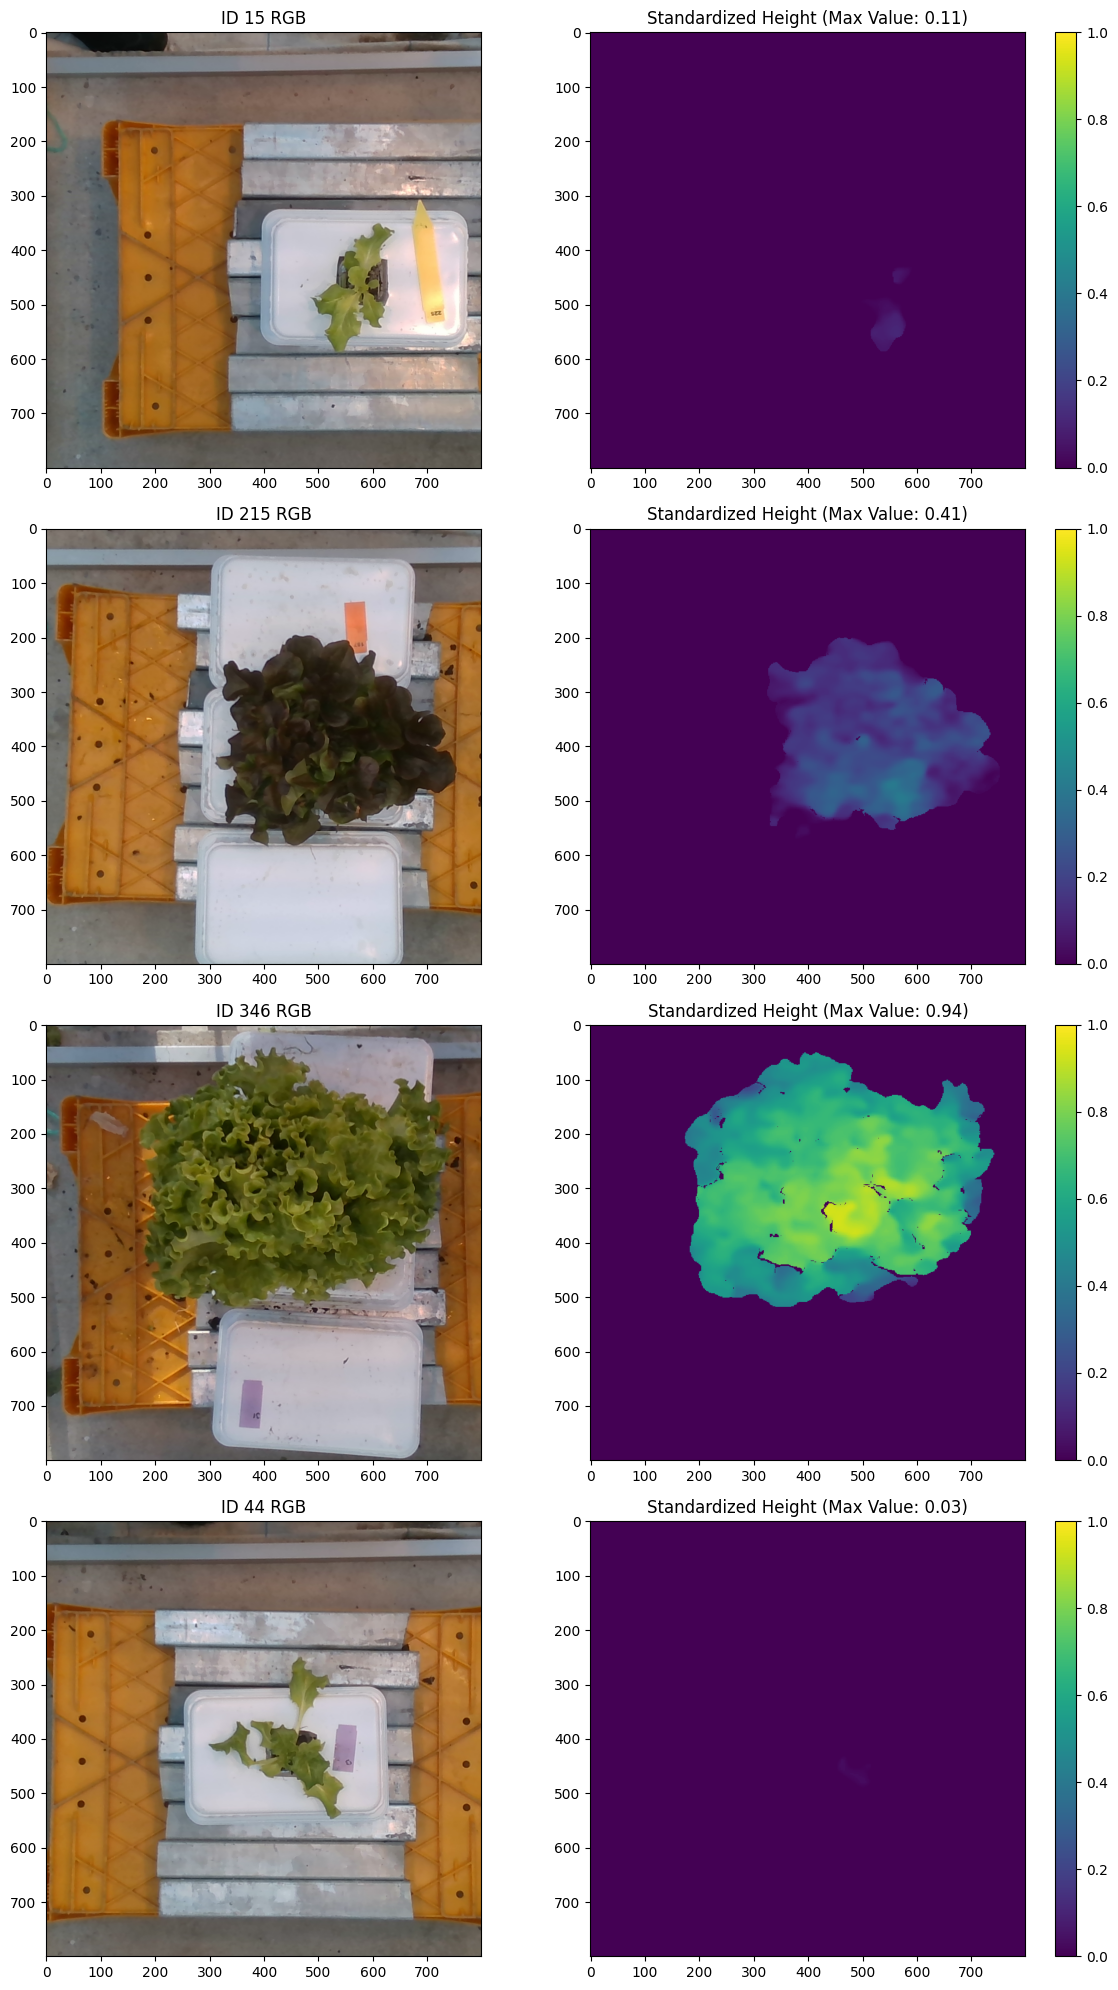

In [16]:
import matplotlib.pyplot as plt

def verify_pipeline(indices, rgb_dict, h_map_dict):
    fig, axes = plt.subplots(len(indices), 2, figsize=(12, 5 * len(indices)))
    for i, idx in enumerate(indices):
        axes[i,0].imshow(rgb_dict[idx])
        axes[i,0].set_title(f"ID {idx} RGB")
        
        h_map = h_map_dict[idx]
        im = axes[i,1].imshow(h_map, cmap='viridis', vmin=0, vmax=1)
        axes[i,1].set_title(f"Standardized Height (Max Value: {np.max(h_map):.2f})")
        plt.colorbar(im, ax=axes[i,1])
        
    plt.tight_layout()
    plt.show()

# Sample a small seedling (ID 15) and a large plant (ID 215)
verify_pipeline([15, 215, 346, 44], cropped_rgb_images_train, height_maps_train)

In [17]:
def isolate_lettuce_with_mask(depth_map, mask):
    """
    Isolates lettuce using a pre-computed segmentation mask and 
    applies height-relative normalization.
    """
    # 1. Ensure mask is binary (0 or 1)
    # Using > 0.5 to handle soft masks if necessary
    binary_mask = (mask > 0.5) & (depth_map > 0)
    
    if np.any(binary_mask):
        # 2. Extract min/max from masked area only
        plant_pixels = depth_map[binary_mask]
        d_min = np.min(plant_pixels)
        d_max = np.max(plant_pixels)
        
        # 3. Normalized Mapping (Inverted)
        # Taller parts (low depth) -> 255
        # Lower parts (high depth) -> 0
        norm_depth = np.zeros_like(depth_map, dtype=np.float32)
        
        # Avoid division by zero for flat objects
        denom = (d_max - d_min) if d_max > d_min else 1.0
        norm_depth[binary_mask] = (d_max - depth_map[binary_mask]) / denom
        
        return (norm_depth * 255).astype(np.uint8)
    else:
        return np.zeros_like(depth_map, dtype=np.uint8)

In [18]:
# Mask depth images
cropped_depth_images_masked_train = {img_id: isolate_lettuce_with_mask(cropped_depth_images_train[img_id], cropped_lettuce_masks_train[img_id]) for img_id in cropped_depth_images_train}

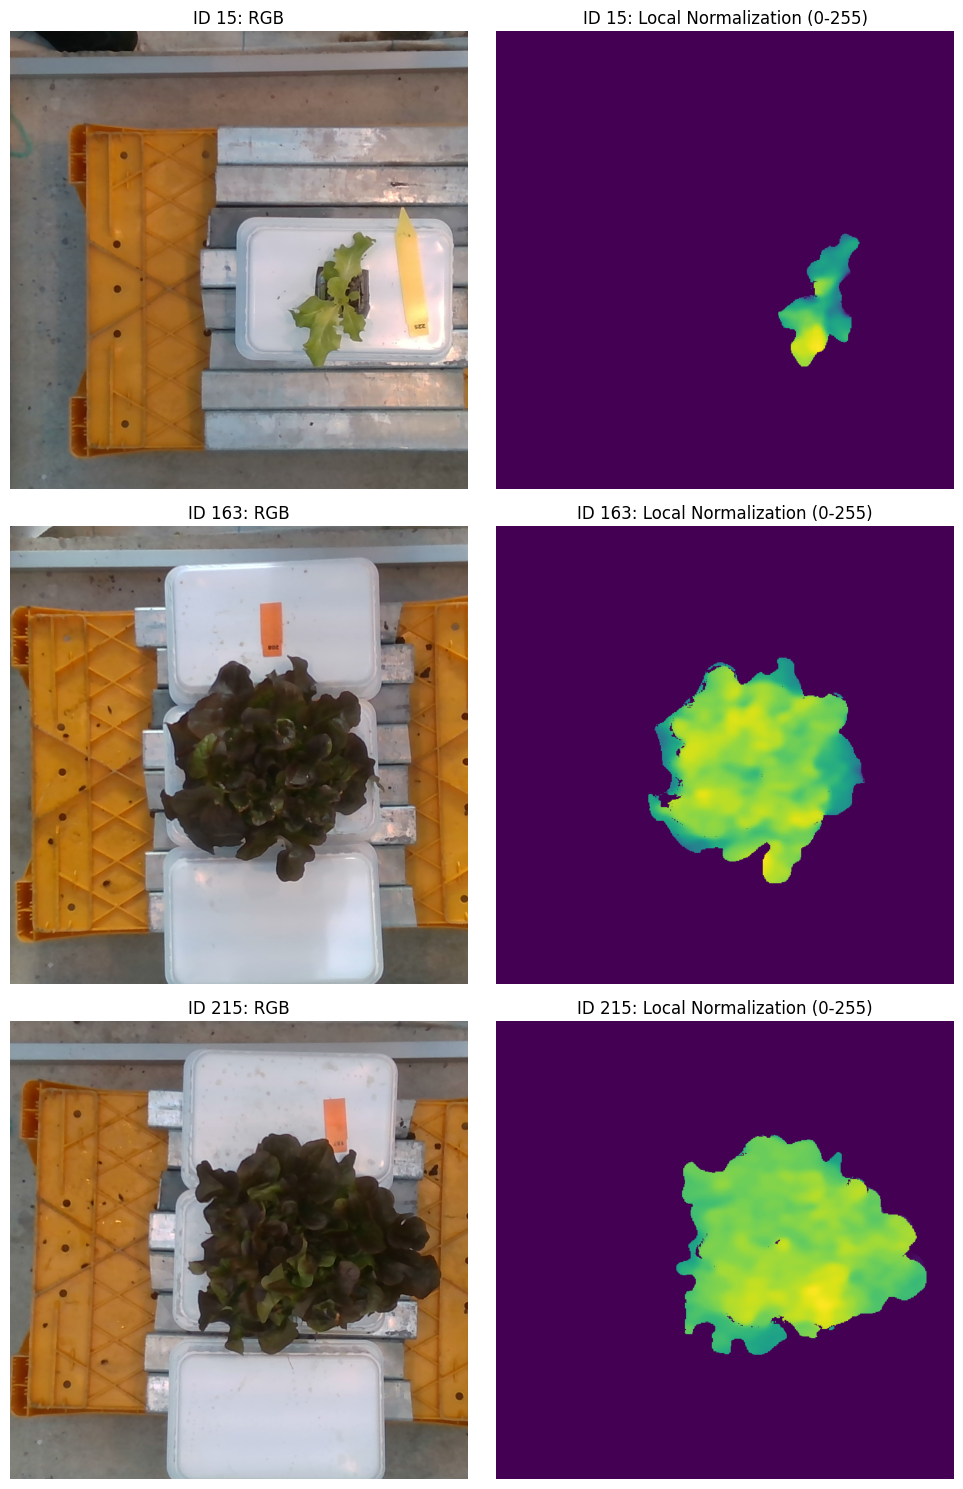

In [19]:
import matplotlib.pyplot as plt

def plot_local_norm_check(indices, rgb_dict, old_masked_dict):
    n = len(indices)
    fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))
    
    for i, idx in enumerate(indices):
        # 1. Original RGB
        axes[i,0].imshow(rgb_dict[idx])
        axes[i,0].set_title(f"ID {idx}: RGB")
        
        # 2. Local Min/Max Masked Depth
        # This is the function you just shared
        axes[i,1].imshow(old_masked_dict[idx], cmap='viridis')
        axes[i,1].set_title(f"ID {idx}: Local Normalization (0-255)")
        
    for ax in axes.ravel():
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Sample a small plant and a large plant to see the "identical brightness" problem
sample_ids = [15, 163, 215] 
plot_local_norm_check(sample_ids, cropped_rgb_images_train, cropped_depth_images_masked_train)

In [20]:
# Resize to 480x480
def resize_image(img, size=(480,480)):
    resized_img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return resized_img

cropped_rgb_images_train_480 = {image_id: resize_image(img, (480,480)) for image_id, img in cropped_rgb_images_train.items()}

cropped_depth_images_masked_train_480 = {image_id: resize_image(img, (480,480)) for image_id, img in cropped_depth_images_masked_train.items()} # Local normalization

height_maps_train_480 = {image_id: resize_image(img, (480,480)) for image_id, img in height_maps_train.items()} # Global normalization


In [22]:
# RGB Augmentations

# Geometric (6 versions)
# - Original
# - 3 rotations (90, 180, 270)
# - 2 flips (horizontal, vertical)

# Color/Light (5 light adjustments)
# - Original
# - +/- 10% and +/- 20% brightness adjustments
# So for each geoemtric version (6) we have 5 color/light versions, total 30 augmentations per image

# Gaussian Noise
# - to the original image only

# Total of 31 augmentations per image (with 248 train images this gives 7688 train images to predict on)
# Gaussian noise and light adjustments are not applied to depth images, only geometric augmentations - but we need to keep them aligned with the RGB images

def apply_geometric(img, geo_idx):
    """Applies one of the 6 Ma et al. geometric transformations."""
    if geo_idx == 0: return img                   # Identity
    if geo_idx == 1: return np.rot90(img, 1)      # 90 deg
    if geo_idx == 2: return np.rot90(img, 2)      # 180 deg
    if geo_idx == 3: return np.rot90(img, 3)      # 270 deg
    if geo_idx == 4: return np.fliplr(img)        # H-Flip
    if geo_idx == 5: return np.flipud(img)        # V-Flip
    return img

def apply_color(img, col_idx):
    """Applies one of the 5 brightness or 1 noise variations."""
    if col_idx == 0: return img
    # Brightness shifts
    factors = {1: 1.1, 2: 0.9, 3: 1.2, 4: 0.8}
    if col_idx in factors:
        return np.clip(img.astype(np.float32) * factors[col_idx], 0, 255).astype(np.uint8)
    # Gaussian Noise (Index 5)
    if col_idx == 5:
        noise = np.random.normal(0, 15, img.shape)
        return np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)
    return img


def consolidate_augmentation(rgb_dict, depth_dict, gt_df=None):
    """
    Consolidated augmentation for training and test sets.
    If gt_df is None, fresh_weight is set to a placeholder for inference.
    """
    output_array = []
    
    for img_id, rgb_orig in rgb_dict.items():
        depth_orig = depth_dict[img_id]
        
        # Determine the target weight
        if gt_df is not None:
            # Matches based on the 'image_id' column in your df_train
            fw_target = gt_df[gt_df['image_id'] == img_id]['FreshWeightShoot'].values[0]
            dw_target = gt_df[gt_df['image_id'] == img_id]['DryWeightShoot'].values[0]
            variety = gt_df[gt_df['image_id'] == img_id]['Variety'].values[0]
        else:
            fw_target = -1.0 # Placeholder for blind test set
            dw_target = -1.0
            variety = 'Unknown'

        # 6 Geometries (g0 to g5)
        for g in range(6):
            rgb_geo = apply_geometric(rgb_orig, g)
            depth_geo = apply_geometric(depth_orig, g)
            
            # 5 Color variations (c0 to c4)
            for c in range(5):
                rgb_aug = apply_color(rgb_geo, c)
                output_array.append({
                    'image_id': img_id,
                    'rgb_image': rgb_aug,
                    'depth_image': depth_geo,
                    'fresh_weight': fw_target,
                    'dry_weight': dw_target,
                    'variety': variety,
                    'aug_type': f'g{g}_c{c}'
                })
                
            # The 31st variation: Noise (c5) only on Identity geometry (g0)
            if g == 0:
                rgb_noise = apply_color(rgb_geo, 5)
                output_array.append({
                    'image_id': img_id,
                    'rgb_image': rgb_noise,
                    'depth_image': depth_geo,
                    'fresh_weight': fw_target,
                    'dry_weight': dw_target,
                    'variety': variety,
                    'aug_type': 'g0_c5'
                })
                
    return np.array(output_array)

# Augment training set with local normalization depth images
aug_train_local = consolidate_augmentation(cropped_rgb_images_train_480, cropped_depth_images_masked_train_480, df_train)
print(f'Augmented training set size - local normalization: {len(aug_train_local)}')
with open('../data/processed/augmented/augmented_train_masked_local_depth_480.pkl', 'wb') as f:
    pickle.dump(aug_train_local, f)

# Augment training set with global normalization height maps
aug_train_global = consolidate_augmentation(cropped_rgb_images_train_480, height_maps_train_480, df_train)
print(f'Augmented training set size - global normalization: {len(aug_train_global)}')
with open('../data/processed/augmented/augmented_train_masked_global_480.pkl', 'wb') as f:
    pickle.dump(aug_train_global, f)

# Save to disk so don't have to regenerate every time


Augmented training set size - local normalization: 7130
Augmented training set size - global normalization: 7130
